In [ ]:
# Cell 1: Imports and Device Setup
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
import itertools
import seaborn as sns
import csv
import os

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
# Cell 2: Load Data
ticker = '^JKLQ45'
# Ensure to use a recent end date if you want up-to-date data for forecasting later
# For reproducibility of training, you might fix the end_date.
# For actual forecasting, you'd use the latest possible data.
df_raw = yf.download(ticker, start='2005-01-01', end='2025-05-27') # Or a more dynamic end_date
print("✅ Data loaded successfully.")
print(f"Data shape: {df_raw.shape}")

[*********************100%***********************]  1 of 1 completed

✅ Data loaded successfully.
Data shape: (4946, 5)


In [ ]:
# Cell 3: EDA & Quality Checks - Part 1
# Data quality checks
print("Null values per column:")
print(df_raw.isnull().sum())
print("\nData types:")
print(df_raw.dtypes)

Null values per column:
Price   Ticker 
Close   ^JKLQ45    0
High    ^JKLQ45    0
Low     ^JKLQ45    0
Open    ^JKLQ45    0
Volume  ^JKLQ45    0
dtype: int64

Data types:
Price   Ticker 
Close   ^JKLQ45    float64
High    ^JKLQ45    float64
Low     ^JKLQ45    float64
Open    ^JKLQ45    float64
Volume  ^JKLQ45      int64
dtype: object


In [ ]:
# Cell 5: Prepare DataFrame for Model
df = df_raw[['Close']].copy() # Use .copy() to avoid SettingWithCopyWarning
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)

<Figure size 1400x600 with 0 Axes>

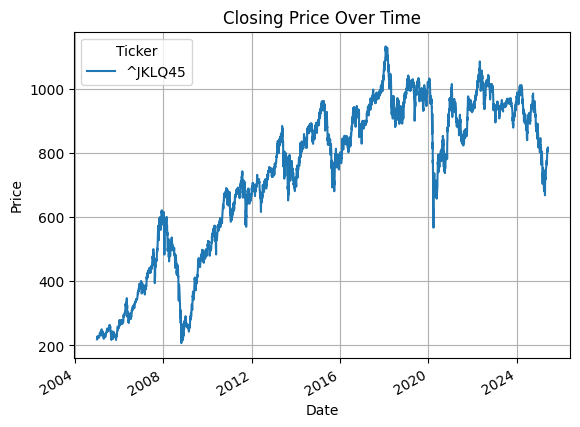

In [ ]:
# Cell 6: Plotting Function and Initial Plot
def plot_data(df_to_plot, title="Closing Price Over Time"):
    plt.figure(figsize=(14,6))
    df_to_plot['Close'].plot()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

plot_data(df)

In [ ]:
# Cell 7: Preprocessing - Scaling
scaler = MinMaxScaler()

# df[['Close']] adalah DataFrame.
# scaler.fit_transform akan mengembalikan NumPy array.
# Mari kita gunakan nama yang sangat jelas untuk NumPy array ini.
scaled_close_prices_numpy = scaler.fit_transform(df[['Close']])

# Jika Anda memerlukan DataFrame yang sudah di-scale untuk keperluan lain (misalnya, plot), Anda bisa membuatnya:
# df_scaled_for_plotting = pd.DataFrame(scaled_close_prices_numpy, columns=['Close'], index=df.index)

# Verifikasi untuk memastikan:
print(f"Shape of scaled_close_prices_numpy: {scaled_close_prices_numpy.shape}")
print(f"Type of scaled_close_prices_numpy: {type(scaled_close_prices_numpy)}")
# Output seharusnya:
# Shape of scaled_close_prices_numpy: (xxxx, 1)
# Type of scaled_close_prices_numpy: <class 'numpy.ndarray'>

Shape of scaled_close_prices_numpy: (4946, 1)
Type of scaled_close_prices_numpy: <class 'numpy.ndarray'>


In [ ]:
# Cell 8: LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_lstm_dims=[64, 32], hidden_dense_dim=16,
                output_dim=1, dropout_p=0.2):
        super(LSTMModel, self).__init__()

        self.lstm_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        current_input_dim = input_dim
        for i, h_dim in enumerate(hidden_lstm_dims):
            is_last_lstm = (i == len(hidden_lstm_dims) - 1)

            self.lstm_layers.append(
                nn.LSTM(current_input_dim, h_dim, batch_first=True, num_layers=1)
            )
            self.layer_norms.append(nn.LayerNorm(h_dim))

            dropout_rate = dropout_p # Consistent dropout for all LSTM layers' outputs if feeding to next LSTM
            if is_last_lstm: # If it's the last LSTM, its output goes to Dense, maybe different dropout
                dropout_rate = dropout_p / 2

            self.dropouts.append(nn.Dropout(dropout_rate))
            current_input_dim = h_dim

        self.fc1 = nn.Linear(hidden_lstm_dims[-1], hidden_dense_dim)
        self.relu = nn.ReLU()
        # Dropout before the final layer can also be beneficial
        self.fc_dropout = nn.Dropout(dropout_p / 2)
        self.fc2 = nn.Linear(hidden_dense_dim, output_dim)

    def forward(self, x):
        for i in range(len(self.lstm_layers)):
            lstm_out, _ = self.lstm_layers[i](x)

            if i < len(self.lstm_layers) - 1:
                out_normalized = self.layer_norms[i](lstm_out)
                x = self.dropouts[i](out_normalized) # Output of intermediate LSTM layers
            else:
                # For the last LSTM layer, take only the last time step's output
                out_last_step = lstm_out[:, -1, :]
                out_normalized = self.layer_norms[i](out_last_step)
                x = self.dropouts[i](out_normalized) # Output of the last LSTM layer (last time step)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc_dropout(x) # Added dropout
        x = self.fc2(x)
        return x

In [ ]:
# Cell 9: Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=30, verbose=False, delta=0, path='temp_best_model_for_run.pth'): # Changed path
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.best_epoch = 0

    def __call__(self, val_loss, model, current_epoch=None):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_epoch = current_epoch
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_epoch = current_epoch
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to {self.path}...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# Cell 10: Data Preparation and Model Utility Functions

def create_sequences(data_values_numpy, seq_length): # data_values_numpy adalah NumPy array
    xs, ys = [], []
    # ... (sisa fungsi sama, menggunakan data_values_numpy)
    for i in range(len(data_values_numpy) - seq_length):
        x = data_values_numpy[i:(i + seq_length)]
        y = data_values_numpy[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


def prepare_data(scaled_data_numpy_array, seq_length, batch_size, device): # Menerima NumPy array
    X, y = create_sequences(scaled_data_numpy_array, seq_length)
    # ... (sisa fungsi sama)
    total_len = len(X)
    train_end = int(0.7 * total_len)
    val_end = int(0.9 * total_len)

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    train_data = TensorDataset(torch.from_numpy(X_train).float().to(device), torch.from_numpy(y_train).float().to(device))
    val_data = TensorDataset(torch.from_numpy(X_val).float().to(device), torch.from_numpy(y_val).float().to(device))
    test_data = TensorDataset(torch.from_numpy(X_test).float().to(device), torch.from_numpy(y_test).float().to(device))

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def train_model_run(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,
                es_patience=30, lr_patience=20):
    model.to(device)

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=lr_patience)
    # Path for EarlyStopping is specific to this run, will be overwritten by next run.
    early_stopper = EarlyStopping(patience=es_patience, verbose=False, path='temp_best_model_for_run.pth')

    train_losses_epoch = []
    val_losses_epoch = []

    for epoch in range(num_epochs):
        model.train()
        batch_train_losses = []
        for X_batch, y_batch in train_loader:
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            batch_train_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses_epoch.append(np.mean(batch_train_losses))

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for X_batch_val, y_batch_val in val_loader:
                val_pred = model(X_batch_val)
                val_loss = criterion(val_pred, y_batch_val)
                batch_val_losses.append(val_loss.item())
        current_val_loss = np.mean(batch_val_losses) # Using mean loss for scheduler & early stopping
        val_losses_epoch.append(current_val_loss)

        scheduler.step(current_val_loss)
        early_stopper(current_val_loss, model, current_epoch=epoch + 1)

        if (epoch + 1) % 10 == 0 or epoch + 1 == num_epochs or early_stopper.early_stop:
            # For RMSE, we need to aggregate all val predictions and true values
            model.eval()
            all_val_preds_scaled = []
            all_val_true_scaled = []
            with torch.no_grad():
                for Xb_val, yb_val in val_loader:
                    p_val = model(Xb_val)
                    all_val_preds_scaled.extend(p_val.cpu().numpy())
                    all_val_true_scaled.extend(yb_val.cpu().numpy())

            # RMSE calculation (on scaled data for epoch monitoring)
            # Note: scaler is not passed here, so this RMSE is on scaled values.
            # For final evaluation, we use unscaled.
            val_rmse_scaled = root_mean_squared_error(all_val_true_scaled, all_val_preds_scaled)
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses_epoch[-1]:.4f} | Val Loss (MSE for ES): {current_val_loss:.4f} | Val RMSE (Scaled): {val_rmse_scaled:.4f}")

        if early_stopper.early_stop:
            print(f"🛑 Early stopping triggered at Epoch {epoch + 1}. Best Epoch: {early_stopper.best_epoch}")
            break

    # Load the best model state from this training run (saved by EarlyStopping)
    model.load_state_dict(torch.load(early_stopper.path))
    if os.path.exists(early_stopper.path): # Clean up temp file
        os.remove(early_stopper.path)
    return model, early_stopper.best_epoch, train_losses_epoch, val_losses_epoch


def evaluate_model_performance(model, test_loader, scaler_obj, device):
    model.eval()
    test_preds_scaled, test_true_scaled = [], []

    with torch.no_grad():
        for Xb_test, yb_test in test_loader:
            Xb_test = Xb_test.to(device) # Ensure data is on the correct device
            p_test = model(Xb_test)
            test_preds_scaled.extend(p_test.cpu().numpy())
            test_true_scaled.extend(yb_test.cpu().numpy())

    test_preds_unscaled = scaler_obj.inverse_transform(np.array(test_preds_scaled).reshape(-1, 1))
    test_true_unscaled = scaler_obj.inverse_transform(np.array(test_true_scaled).reshape(-1, 1))

    rmse = root_mean_squared_error(test_true_unscaled, test_preds_unscaled)
    mape = np.mean(np.abs((test_true_unscaled - test_preds_unscaled) / test_true_unscaled)) * 100

    print(f"✅ Final Test Metrics: RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
    return rmse, mape

def save_results_to_csv(results_list, filename='results.csv'):
    # Adjusted fieldnames
    fieldnames = ['Learning Rate', 'Sequence Length', 'Batch Size', 'Epochs Set', 'Best Epoch Found',
                'Test RMSE', 'Test MAPE (%)']
    write_header = not os.path.exists(filename) or os.path.getsize(filename) == 0


    with open(filename, mode='a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            writer.writeheader()
        writer.writerows(results_list)

In [ ]:
# Cell 11: Hyperparameter Grid
params_grid = {
    "learning_rate": [0.001, 0.0001],
    "seq_length": [5, 10],          # Length of input sequence X
    "batch_size": [8, 16, 32, 64],
    "num_epochs_set": [100, 150, 200]
}
# For a full run, you can expand batch_size and num_epochs_set
# params_grid = {
#     "learning_rate": [0.001, 0.0001],
#     "seq_length": [5, 10],
#     "batch_size": [8, 16, 32, 64],
#     "num_epochs_set": [100, 150, 200]
# }

In [ ]:
# Cell 12: Hyperparameter Tuning Loop
all_run_results = []
best_overall_rmse = np.inf
overall_best_model_path = 'overall_best_model.pth'

results_csv_path = 'resultslstm.csv'
if os.path.exists(results_csv_path):
    print(f"Existing {results_csv_path} found. Appending new results.")
    # Untuk run baru, Anda mungkin ingin menghapus file lama:
    # if os.path.exists(results_csv_path): os.remove(results_csv_path)

for lr, seq_len, batch_size, num_epochs in itertools.product(*params_grid.values()):
    print(f"\n🔁 Training with params: LR={lr}, SEQ_LEN={seq_len}, BATCH_SIZE={batch_size}, EPOCHS_SET={num_epochs}")

    # Gunakan variabel NumPy array yang didefinisikan di Cell 7
    train_loader, val_loader, test_loader = prepare_data(
        scaled_close_prices_numpy, # <<<--- PASTIKAN INI ADALAH NAMA VARIABEL NumPy DARI CELL 7
        seq_len,
        batch_size,
        device
    )

    # input_dim dan output_dim akan menjadi 1 jika scaled_close_prices_numpy.shape[1] adalah 1
    model = LSTMModel(input_dim=scaled_close_prices_numpy.shape[1],
                    hidden_lstm_dims=[64, 32],
                    hidden_dense_dim=16,
                    output_dim=scaled_close_prices_numpy.shape[1],
                    dropout_p=0.2).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    trained_model, best_epoch_found, _, _ = train_model_run(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device,
        es_patience=15,
        lr_patience=10
    )

    current_rmse, current_mape = evaluate_model_performance(trained_model, test_loader, scaler, device) # scaler di sini adalah instance MinMaxScaler dari Cell 7

    run_result_data = {
        'Learning Rate': lr,
        'Sequence Length': seq_len,
        'Batch Size': batch_size,
        'Epochs Set': num_epochs,
        'Best Epoch Found': best_epoch_found,
        'Test RMSE': round(current_rmse, 2),
        'Test MAPE (%)': round(current_mape, 2)
    }
    all_run_results.append(run_result_data)

    save_results_to_csv([run_result_data], filename=results_csv_path)

    if current_rmse < best_overall_rmse:
        best_overall_rmse = current_rmse
        torch.save({
            'model_state_dict': trained_model.state_dict(),
            'params': {
                'learning_rate': lr,
                'sequence_length': seq_len,
                'batch_size': batch_size,
                'num_epochs_set': num_epochs,
                'best_epoch_found': best_epoch_found
            },
            'metrics': {
                'rmse': current_rmse,
                'mape': current_mape
            },
            'scaler_params': {
                'min_': scaler.min_.tolist(), # 'scaler' dari Cell 7
                'scale_': scaler.scale_.tolist() # 'scaler' dari Cell 7
            }
        }, overall_best_model_path)
        print(f"🏆 New OVERALL best model saved: LR={lr}, SeqLen={seq_len}, Batch={batch_size}, "
            f"EpochsSet={num_epochs}, BestEpoch={best_epoch_found}, RMSE={current_rmse:.2f}, MAPE={current_mape:.2f}%")

print("\nHyperparameter tuning finished.")
if all_run_results:
    print(f"All results saved to {results_csv_path}")
    if os.path.exists(overall_best_model_path):
        print(f"Overall best model saved to {overall_best_model_path} with RMSE: {best_overall_rmse:.2f}")
    else:
        print("No overall best model was saved.")
else:
    print("No runs completed or no results generated.")


🔁 Training with params: LR=0.001, SEQ_LEN=5, BATCH_SIZE=8, EPOCHS_SET=100
Epoch 10/100 | Train Loss: 0.0400 | Val Loss (MSE for ES): 0.0101 | Val RMSE (Scaled): 0.1006
Epoch 20/100 | Train Loss: 0.0721 | Val Loss (MSE for ES): 0.0429 | Val RMSE (Scaled): 0.2071
Epoch 28/100 | Train Loss: 0.0738 | Val Loss (MSE for ES): 0.0679 | Val RMSE (Scaled): 0.2605
🛑 Early stopping triggered at Epoch 28. Best Epoch: 13
✅ Final Test Metrics: RMSE = 77.45, MAPE = 6.65%
🏆 New OVERALL best model saved: LR=0.001, SeqLen=5, Batch=8, EpochsSet=100, BestEpoch=13, RMSE=77.45, MAPE=6.65%

🔁 Training with params: LR=0.001, SEQ_LEN=5, BATCH_SIZE=8, EPOCHS_SET=150
Epoch 10/150 | Train Loss: 0.0692 | Val Loss (MSE for ES): 0.0164 | Val RMSE (Scaled): 0.1282
Epoch 20/150 | Train Loss: 0.0366 | Val Loss (MSE for ES): 0.0099 | Val RMSE (Scaled): 0.0995
Epoch 30/150 | Train Loss: 0.0566 | Val Loss (MSE for ES): 0.0152 | Val RMSE (Scaled): 0.1234
Epoch 40/150 | Train Loss: 0.0486 | Val Loss (MSE for ES): 0.0050 | V

In [ ]:
# Cell 13: Analyze Results from CSV
try:
    df_results = pd.read_csv('resultslstm.csv')

    print("\n📊 All Run Results from CSV:")
    print(df_results)

    # Sort DataFrame by RMSE (ascending: best first)
    top_10_runs = df_results.sort_values(by='Test RMSE', ascending=True).head(10)

    print("\n🏆 Top 10 Best Runs by RMSE from CSV:")
    # Round values for cleaner output before printing
    top_10_runs_display = top_10_runs.copy()
    top_10_runs_display['Test RMSE'] = top_10_runs_display['Test RMSE'].round(2)
    top_10_runs_display['Test MAPE (%)'] = top_10_runs_display['Test MAPE (%)'].round(2)
    print(top_10_runs_display.to_string(index=False))

except FileNotFoundError:
    print("results.csv not found. Please run the hyperparameter tuning first.")
except pd.errors.EmptyDataError:
    print("results.csv is empty. No results to analyze.")


📊 All Run Results from CSV:
    Learning Rate  Sequence Length  Batch Size  Epochs Set  Best Epoch Found  \
0          0.0010                5           8         100                13   
1          0.0010                5           8         150                94   
2          0.0010                5           8         200                16   
3          0.0010                5          16         100                 2   
4          0.0010                5          16         150                 6   
5          0.0010                5          16         200                 3   
6          0.0010                5          32         100                66   
7          0.0010                5          32         150                67   
8          0.0010                5          32         200                50   
9          0.0010                5          64         100                28   
10         0.0010                5          64         150                54   
11         

In [ ]:
# Cell 14: Forecast with Best Model - Setup
# Add numpy scalar to safe globals for proper loading
torch.serialization.add_safe_globals(['numpy._core.multiarray.scalar'])

# Load the overall best model and its parameters
try:
    checkpoint = torch.load(overall_best_model_path, map_location=device, weights_only=False) # explicitly set weights_only=False

    best_params = checkpoint['params']
    forecast_seq_length = best_params['sequence_length']

    # Re-initialize model with saved architecture details (if they were dynamic)
    # For this fixed architecture, it's straightforward:
    forecast_model = LSTMModel(input_dim=1, hidden_lstm_dims=[64, 32],
                            hidden_dense_dim=16, output_dim=1, dropout_p=0.2)
    forecast_model.load_state_dict(checkpoint['model_state_dict'])
    forecast_model.to(device)
    forecast_model.eval()

    # Restore scaler
    forecast_scaler = MinMaxScaler()
    forecast_scaler.min_ = np.array(checkpoint['scaler_params']['min_'])
    forecast_scaler.scale_ = np.array(checkpoint['scaler_params']['scale_'])

    print("✅ Best model and scaler loaded for forecasting.")
    print(f"Best model parameters: {best_params}")
    print(f"Best model metrics: RMSE={checkpoint['metrics']['rmse']:.2f}, MAPE={checkpoint['metrics']['mape']:.2f}%")

except FileNotFoundError:
    print(f"{overall_best_model_path} not found. Cannot proceed with forecasting.")
    forecast_model = None # Ensure it's None if not loaded
except KeyError as e:
    print(f"KeyError loading checkpoint: {e}. The saved model might have a different structure.")
    forecast_model = None

✅ Best model and scaler loaded for forecasting.
Best model parameters: {'learning_rate': 0.001, 'sequence_length': 10, 'batch_size': 32, 'num_epochs_set': 200, 'best_epoch_found': 91}
Best model metrics: RMSE=10.86, MAPE=0.94%


In [ ]:
# Cell 15: Download Latest Data for Forecasting & Prepare
if forecast_model:
    from datetime import date, timedelta
    today_str = date.today().strftime('%Y-%m-%d')

    df_forecast_base = yf.download(ticker, start="2005-01-01")
    data_for_forecast = df_forecast_base[['Close']].values # Pastikan ini juga (xxxx, 1)

    # Gunakan scaler yang sudah di-restore
    scaled_data_for_forecast = forecast_scaler.transform(data_for_forecast)
    print(f"Latest data downloaded for {ticker}. Shape: {data_for_forecast.shape}")
else:
    print("Forecasting setup failed. Skipping data download.")

[*********************100%***********************]  1 of 1 completed

Latest data downloaded for ^JKLQ45. Shape: (4947, 1)


In [ ]:
# Cell 16: Prediction Function for Future Dates
def predict_future_days(model, last_known_scaled_data, scaler_obj, sequence_length, n_future_days=7):
    model.eval()
    device_of_model = next(model.parameters()).device

    # Take the last `sequence_length` known data points as the initial sequence
    current_sequence_scaled = last_known_scaled_data[-sequence_length:]

    # Reshape for the model: [1, sequence_length, num_features]
    current_sequence_tensor = torch.tensor(current_sequence_scaled, dtype=torch.float32).unsqueeze(0).to(device_of_model)

    future_predictions_scaled = []

    with torch.no_grad():
        for _ in range(n_future_days):
            # Predict the next step
            next_step_pred_scaled = model(current_sequence_tensor) # Output shape [1, 1]
            future_predictions_scaled.append(next_step_pred_scaled.item())

            # Prepare the predicted step to be added to the sequence
            new_val_tensor = next_step_pred_scaled.unsqueeze(0) # Shape becomes [1, 1, 1]

            # Update the sequence: drop the oldest point, append the new prediction
            current_sequence_tensor = torch.cat((current_sequence_tensor[:, 1:, :], new_val_tensor), dim=1)

    # Inverse transform to get original prices
    future_predictions_unscaled = scaler_obj.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))
    return future_predictions_unscaled


🗓️ Forecast for the next 7 business days:
2025-05-28: IDR 814.01
2025-05-29: IDR 812.70
2025-05-30: IDR 811.32
2025-06-02: IDR 809.92
2025-06-03: IDR 808.51
2025-06-04: IDR 807.13
2025-06-05: IDR 805.72


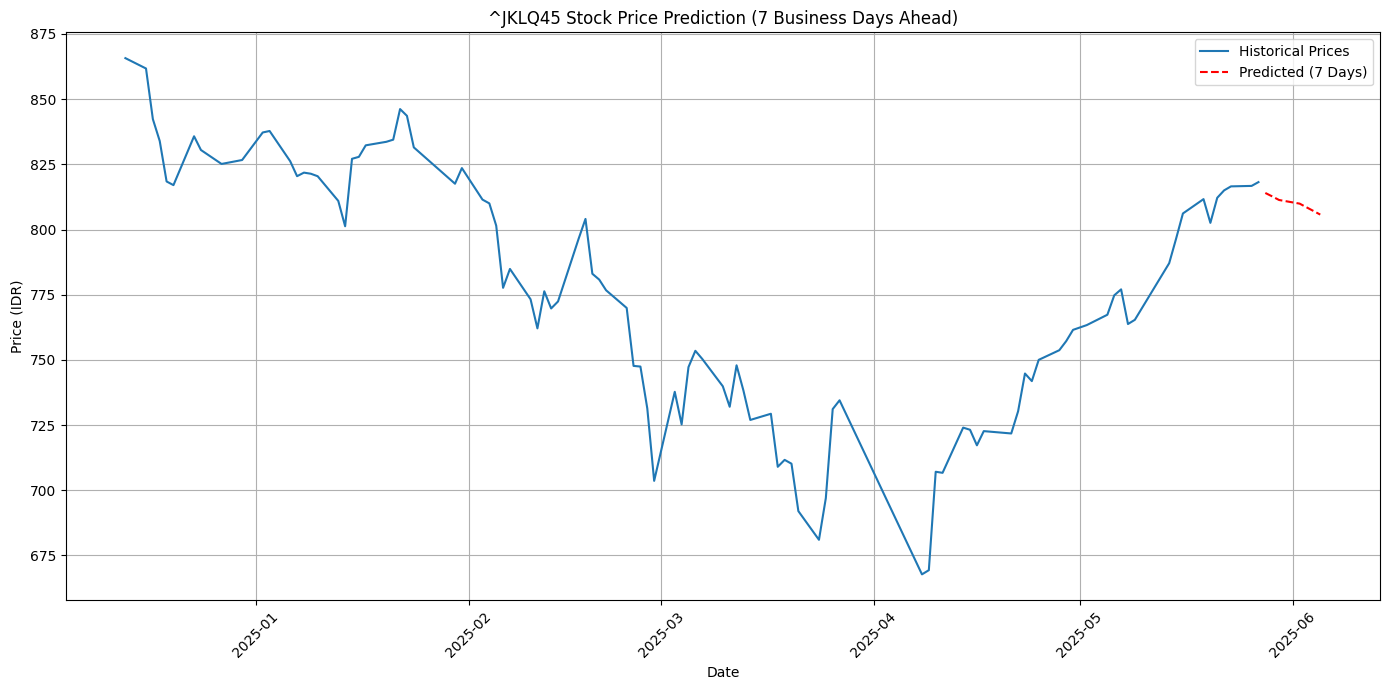

In [ ]:
# Cell 17: Perform and Display Forecast
if forecast_model:
    n_days_to_predict = 7
    future_predictions = predict_future_days(forecast_model,
                                            scaled_data_for_forecast,
                                            forecast_scaler,
                                            forecast_seq_length,
                                            n_future_days=n_days_to_predict)

    last_historical_date = df_forecast_base.index[-1]
    future_forecast_dates = pd.bdate_range(start=last_historical_date + BDay(), periods=n_days_to_predict).date

    print(f"\n🗓️ Forecast for the next {n_days_to_predict} business days:")
    for date_val, price_val in zip(future_forecast_dates, future_predictions):
        print(f"{date_val}: IDR {price_val[0]:.2f}")

    # Plotting
    plt.figure(figsize=(14, 7))
    # Plot historical data (e.g., last 100 days)
    plt.plot(df_forecast_base.index[-100:], df_forecast_base['Close'][-100:], label="Historical Prices")
    # Plot predicted future prices
    plt.plot(future_forecast_dates, future_predictions, label=f"Predicted ({n_days_to_predict} Days)", color='red', linestyle='--')

    plt.title(f"{ticker} Stock Price Prediction ({n_days_to_predict} Business Days Ahead)")
    plt.xlabel("Date")
    plt.ylabel("Price (IDR)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot perform forecast as the model was not loaded successfully.")